### Predição de temperatura minima diaria

In [1]:
import keras
import pandas as pd 
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import datetime

In [2]:
data = pd.read_csv('dataset/daily-minimum-temperatures-in-me.csv')

In [3]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [4]:
data['Daily minimum temperatures'] = data['Daily minimum temperatures'].apply(lambda x: x.replace('?', ''))

In [5]:
data['Daily minimum temperatures'] = data['Daily minimum temperatures'].astype(float)

In [6]:
data.head()

,Daily minimum temperatures
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [7]:
data.isnull().sum()

Daily minimum temperatures    0
dtype: int64

> Não há valores nulos

Verificando se há dias faltando

In [8]:
subset_ = data.copy()
subset_ = subset_.reset_index()
for index in data.index.year.unique():
    sub = subset_[subset_['Date'].dt.year == index]
    print(f" {index} : dias {sub.shape}")

 1981 : dias (365, 2)
 1982 : dias (365, 2)
 1983 : dias (365, 2)
 1984 : dias (365, 2)
 1985 : dias (365, 2)
 1986 : dias (365, 2)
 1987 : dias (365, 2)
 1988 : dias (365, 2)
 1989 : dias (365, 2)
 1990 : dias (365, 2)


### Analise exploratoria dos dados

<Axes: xlabel='Date'>

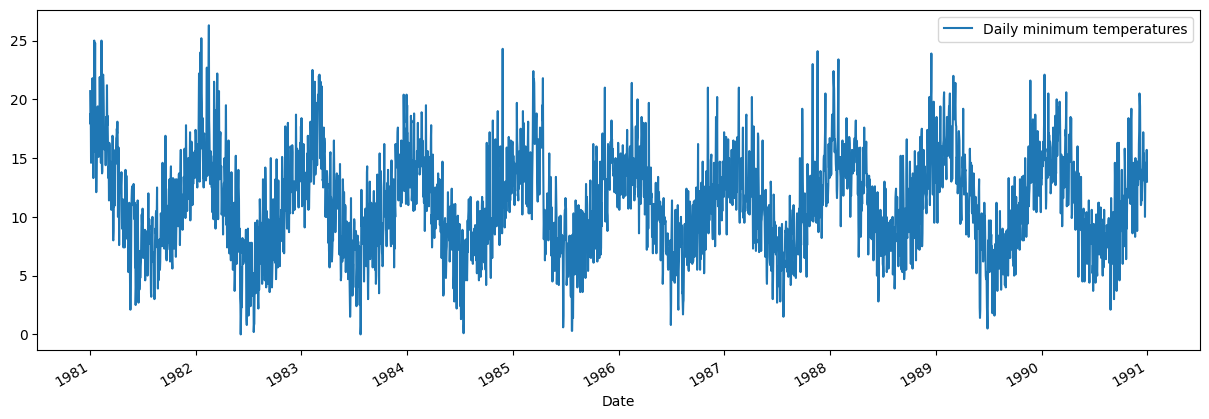

In [9]:
data.plot(figsize=(15,5))

In [10]:
data['mes'] = data.index.month_name('pt_BR')
data['ano'] = data.index.year

### temperatura media anual

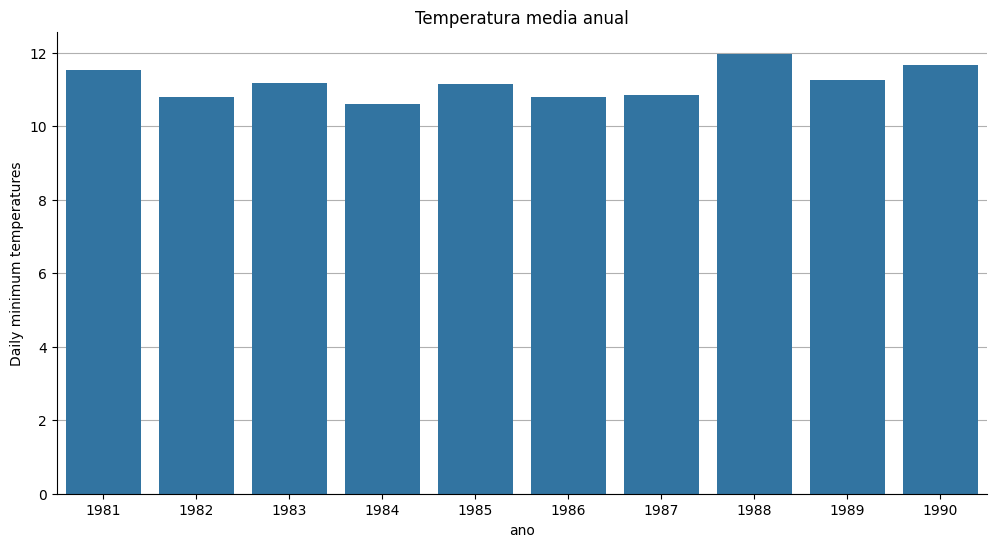

In [11]:
# temperatura media anual 

subset  = data.groupby(['ano'])['Daily minimum temperatures'].mean()


plt.figure(figsize=(12,6))
plt.title('Temperatura media anual')
sns.barplot(subset)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.gca().grid(True, axis='y')
plt.gca().set_axisbelow(True)
plt.show()

> Se manteve constante ao longo to tempo

### Temperatura media mensal

In [12]:
subset = data.groupby(['mes'])['Daily minimum temperatures'].mean()

In [13]:
mes = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 
        'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro',
        'Outubro', 'Novembro', 'Dezembro'
        ]

categoria = pd.Categorical(values=subset.index, ordered=False, categories=mes)

In [14]:
subset = subset.reset_index()
subset['mes'] = categoria
subset = subset.sort_values(by='mes')

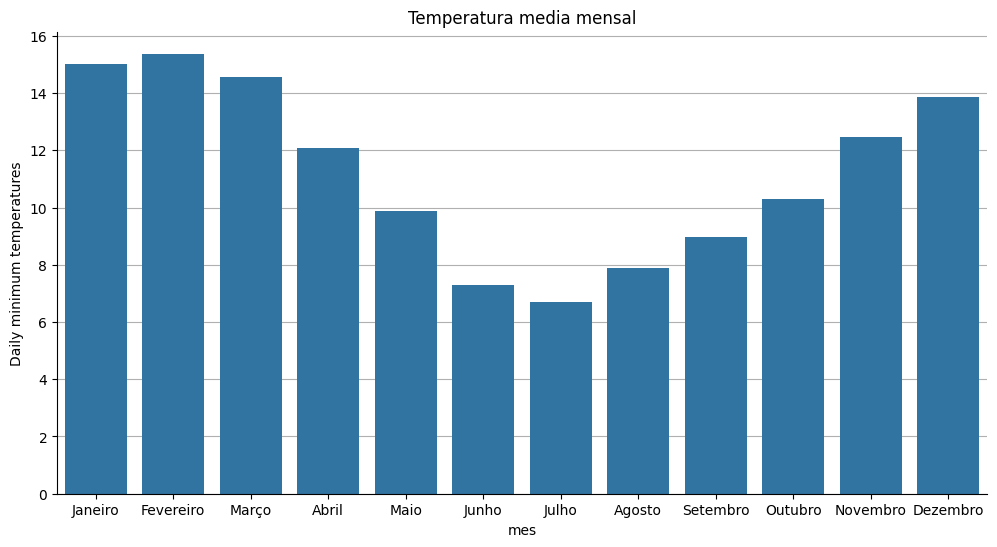

In [15]:
plt.figure(figsize=(12,6))
plt.title('Temperatura media mensal')
sns.barplot(subset, x='mes', y='Daily minimum temperatures')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.gca().grid(True, axis='y')
plt.gca().set_axisbelow(True)
plt.show()

> os primeiro meses ocorre o decrescimo da temperatura com o aumento crescente a partir de dezembro

### Month plot

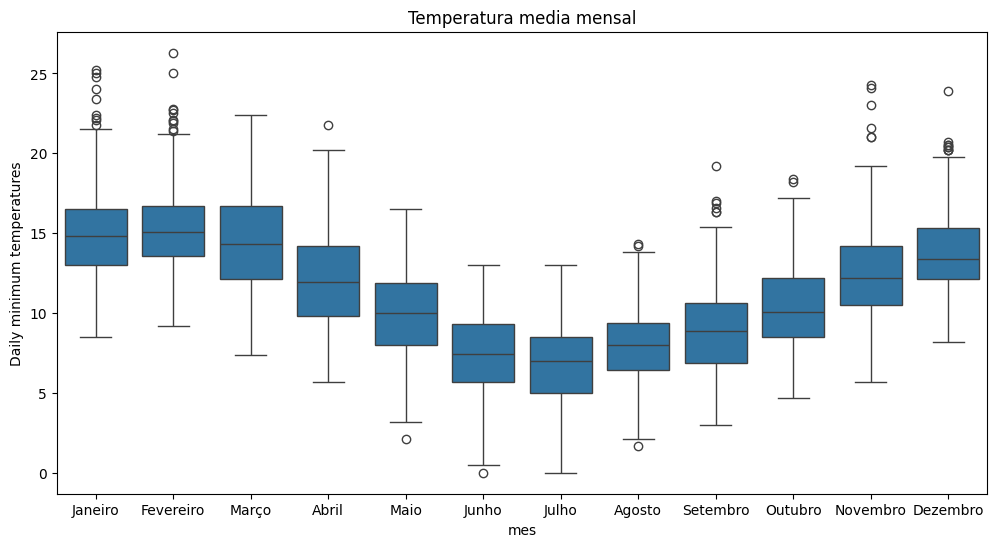

In [16]:
plt.figure(figsize=(12,6))
plt.title('Temperatura media mensal')

sns.boxplot(data=data, x='mes', y='Daily minimum temperatures')
plt.show()

### Histograma

<Axes: xlabel='Daily minimum temperatures', ylabel='Count'>

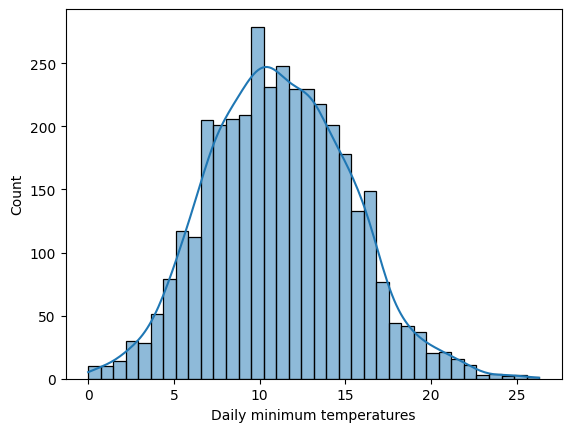

In [17]:
sns.histplot(
    x = data['Daily minimum temperatures'],
    kde = True
)

<Axes: xlabel='Daily minimum temperatures', ylabel='Count'>

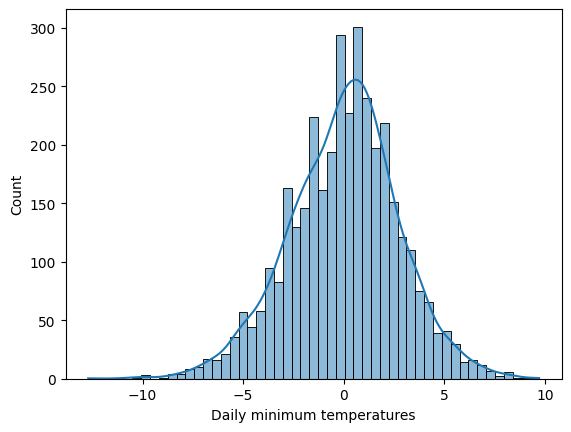

In [18]:
sns.histplot(
    x = data['Daily minimum temperatures'].diff(),
    kde = True
)

### Verificando estacionariedade

In [19]:
mean_rolling = data['Daily minimum temperatures'].rolling(7*4).mean()
std_rolling = data['Daily minimum temperatures'].rolling(7*4).var()

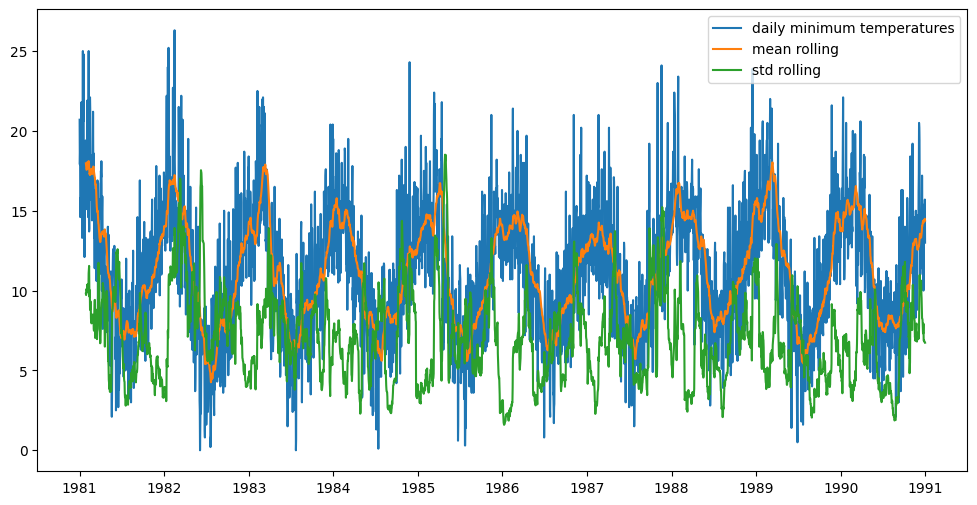

In [20]:
plt.figure(figsize=(12,6))
plt.plot(data['Daily minimum temperatures'], label='daily minimum temperatures')
plt.plot(mean_rolling, label='mean rolling')
plt.plot(std_rolling, label='std rolling')
plt.legend()
plt.show()

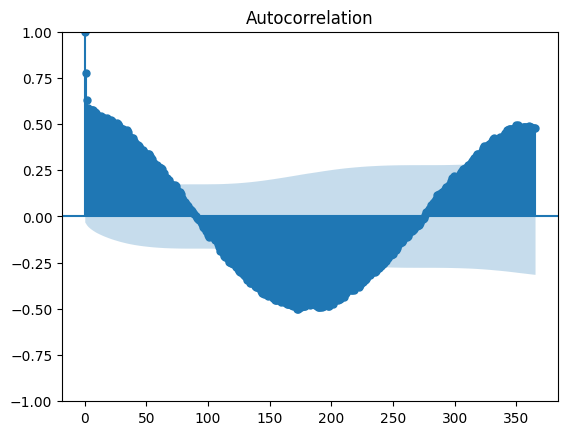

In [41]:
# acf

sm.graphics.tsa.plot_acf(data['Daily minimum temperatures'], lags=365)
plt.show()

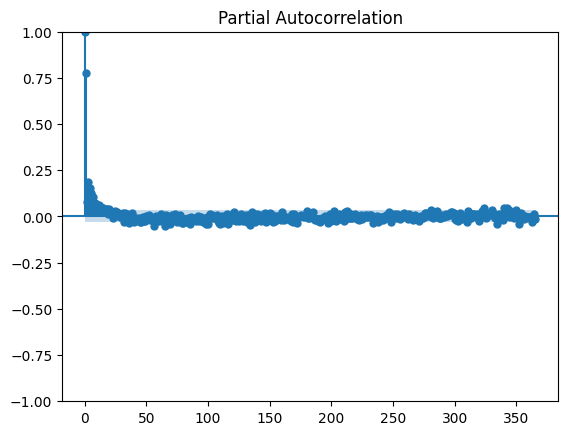

In [42]:
# PACF

sm.graphics.tsa.plot_pacf(data['Daily minimum temperatures'], lags=365)
plt.show()

In [70]:
from arch.unitroot import DFGLS

In [71]:
DFGLS(data['Daily minimum temperatures'])

Test Statistic,-1.217
P-value,0.212
Lags,20


### Decomposição

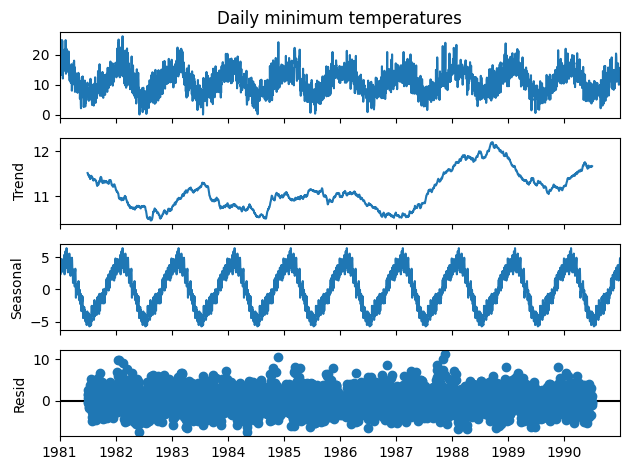

In [51]:
sm.tsa.seasonal_decompose(data['Daily minimum temperatures'], model='additive', period=365).plot()
plt.show()

Downsampling, irei fazer a média semanal da temperatura

In [55]:
subset = data['Daily minimum temperatures']

In [56]:
subset.shape

(3650,)

<Axes: xlabel='Date'>

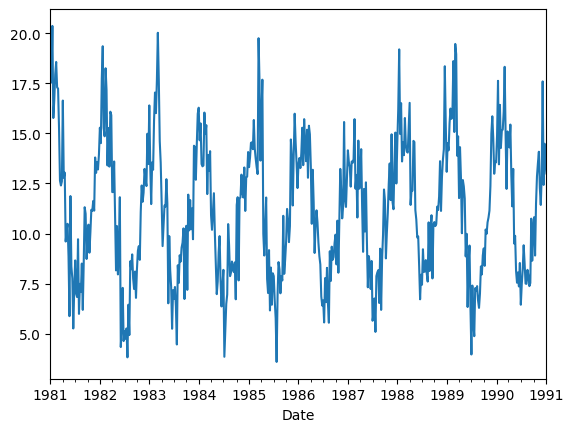

In [57]:
subset.resample('W').mean().plot()

In [72]:
DFGLS(subset.resample('W').mean()).summary()

Test Statistic,-1.978
P-value,0.048
Lags,19


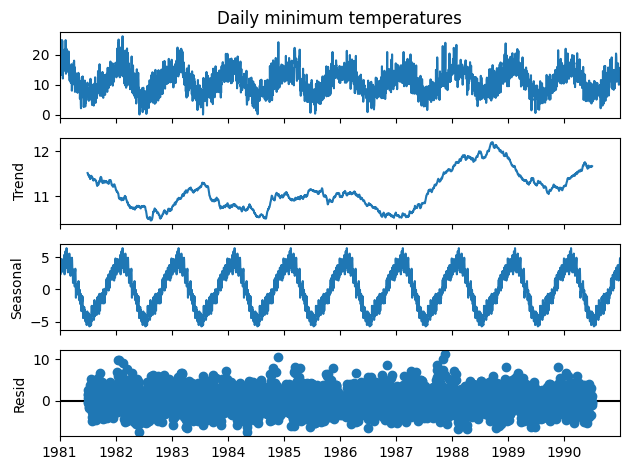

In [73]:
sm.tsa.seasonal_decompose(subset, model='additive', period=365).plot()
plt.show()

## Criando modelo

<Axes: xlabel='Date'>

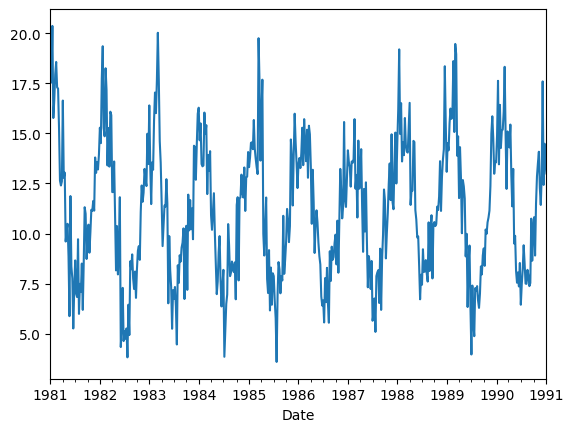

In [75]:
dataset = subset.resample('W').mean()
dataset.plot()

In [76]:
dataset = dataset.reset_index()
dataset = dataset[['Date', 'Daily minimum temperatures']]
dataset = dataset.rename(columns={'Date': 'ds', 'Daily minimum temperatures': 'y'})

> Fiz isso afim de reduz o ruido da serie

In [77]:
import darts
from darts.models import  ExponentialSmoothing
from darts import TimeSeries

c:\Users\mateu\Documents\Norton\Projetos GIT\machine-learning\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\mateu\Documents\Norton\Projetos GIT\machine-learning\venv\Lib\site-packages\fs\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore


In [78]:
series = TimeSeries.from_dataframe(dataset, 'ds', 'y')

<Axes: xlabel='ds'>

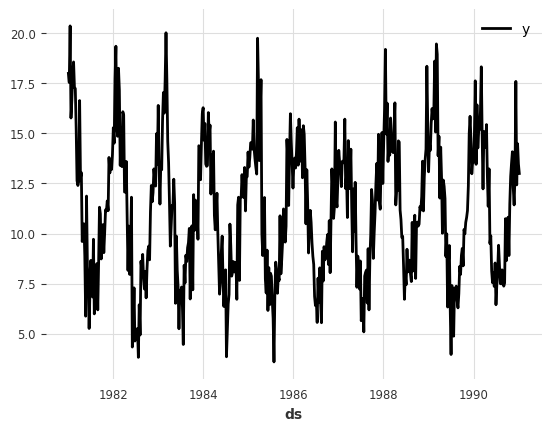

In [79]:
series.plot()

In [80]:
# holt-winter

exp = ExponentialSmoothing(
    trend=None,
    seasonal=darts.utils.utils.SeasonalityMode.ADDITIVE,
    seasonal_periods=52
)
exp.fit(series)

ExponentialSmoothing(trend=None, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=52, random_state=None, kwargs=None)

<Axes: xlabel='ds'>

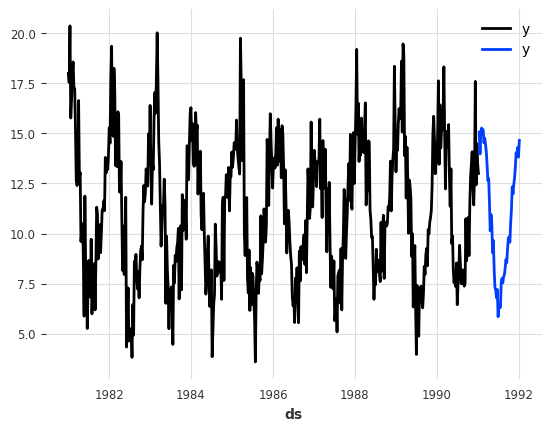

In [81]:
series.plot()
exp.predict(52).plot()

Tensorflow

In [82]:
import numpy as np

In [83]:
series_ = dataset['y']

In [84]:
train, test = series_[:int(len(series_)*0.8)], series_[int(len(series_)*0.8):]

In [85]:
# Escalonando seguindo uma media movel
train_ewan_mean = train.ewm(span=54).mean()
train_ewan_std  = train.ewm(span=54).std()

In [86]:
test_ewan_mean = test.ewm(span=54).mean()
test_ewan_std  = test.ewm(span=54).std()

In [87]:
train_std = (train - train_ewan_mean) / train_ewan_std
test_std = (test - test_ewan_mean) / test_ewan_std

In [88]:
train_std = train_std.dropna()
test_std = test_std.dropna()

In [89]:
def prepare_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [90]:
xtrain, ytrain = prepare_dataset(train_std.values, 54)
xtest, ytest = prepare_dataset(test_std.values, 54)

In [124]:
model = keras.models.Sequential([
    keras.layers.InputLayer(shape=(xtrain.shape[1], 1)),
    keras.layers.GRU(80, return_sequences=True),
    keras.layers.GRU(80, return_sequences=False),
    keras.layers.Dense(1)
])

In [125]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [126]:
tensorboard = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [127]:
model.compile(optimizer='adam', loss='mse')
model.fit(
    xtrain, 
    ytrain, 
    epochs=20, verbose=2, 
    validation_data=(xtest, ytest),
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True),
        tensorboard
    ])

Epoch 1/20
12/12 - 11s - 891ms/step - loss: 0.5662 - val_loss: 0.3419
Epoch 2/20
12/12 - 5s - 416ms/step - loss: 0.3516 - val_loss: 0.2490
Epoch 3/20
12/12 - 2s - 137ms/step - loss: 0.3118 - val_loss: 0.2262
Epoch 4/20
12/12 - 2s - 193ms/step - loss: 0.2933 - val_loss: 0.2151
Epoch 5/20
12/12 - 1s - 101ms/step - loss: 0.2898 - val_loss: 0.2143
Epoch 6/20
12/12 - 2s - 149ms/step - loss: 0.2848 - val_loss: 0.2116
Epoch 7/20
12/12 - 1s - 88ms/step - loss: 0.2786 - val_loss: 0.2048
Epoch 8/20
12/12 - 1s - 79ms/step - loss: 0.2785 - val_loss: 0.2021
Epoch 9/20
12/12 - 1s - 84ms/step - loss: 0.2688 - val_loss: 0.1937
Epoch 10/20
12/12 - 3s - 217ms/step - loss: 0.2633 - val_loss: 0.1879
Epoch 11/20
12/12 - 2s - 203ms/step - loss: 0.2578 - val_loss: 0.1825
Epoch 12/20
12/12 - 4s - 307ms/step - loss: 0.2513 - val_loss: 0.1834
Epoch 13/20
12/12 - 4s - 330ms/step - loss: 0.2411 - val_loss: 0.1808
Epoch 14/20
12/12 - 3s - 269ms/step - loss: 0.2459 - val_loss: 0.2041
Epoch 15/20
12/12 - 3s - 209ms/

In [128]:
pred_train = model.predict(xtrain)

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 237ms/step


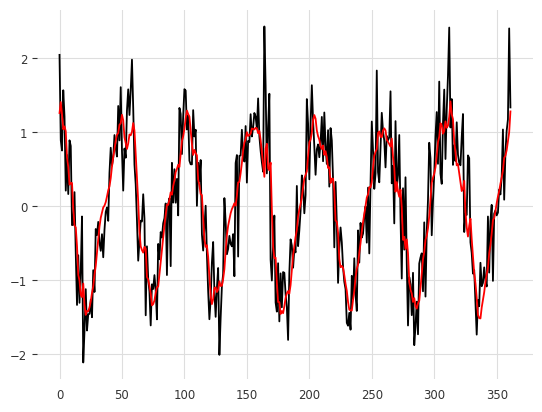

In [129]:
plt.plot(ytrain)
plt.plot(pred_train, color='red')
plt.show()

In [130]:
pred_test = model.predict(xtest)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


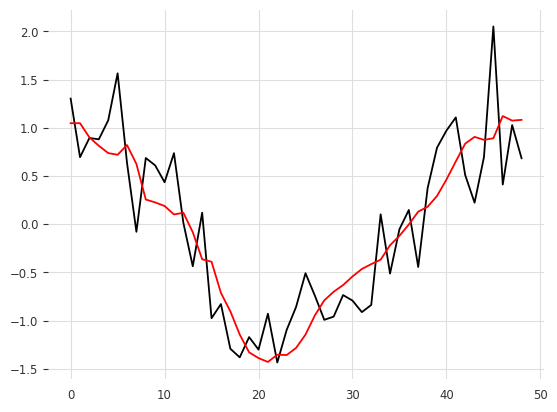

In [131]:
plt.plot(ytest)
plt.plot(pred_test, color='red')
plt.show()

In [132]:
ultimo = xtest[-1].reshape(1,54)
lista = []
for i in range(54):
    pred = model.predict(ultimo, verbose=0)
    lista.append(pred)
    ultimo = np.append(ultimo[0][1:], pred)
    ultimo = ultimo.reshape(1,54)

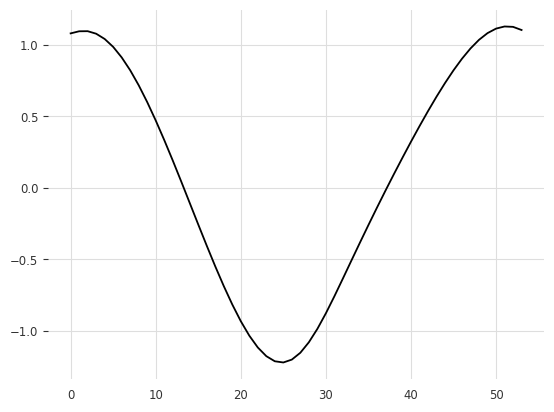

In [133]:
lista = [ i[0][0] for i in lista]
plt.plot(lista) 

In [134]:
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [135]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 8688), started 0:05:50 ago. (Use '!kill 8688' to kill it.)